In [1]:
!python -V

Python 3.9.19


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import pickle

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-green-taxi")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716802920555, experiment_id='1', last_update_time=1716802920555, lifecycle_stage='active', name='nyc-green-taxi', tags={}>

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [8]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [10]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

In [11]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,...,-0.5,0.00,0.00,None,-0.3,-52.80,3.0,1.0,0.00,0.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [12]:
# df = df[df.trip_type == 2]

In [13]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [14]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [15]:
df[categorical] = df[categorical].astype(str)

In [16]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

In [17]:
df[categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19},
 {'PULocationID': '244', 'DOLocationID': '244', 'trip_distance': 3.39},
 {'PULocationID': '75', 'DOLocationID': '213', 'trip_distance': 6.69},
 {'PULocationID': '74', 'DOLocationID': '238', 'trip_distance': 2.34},
 {'PULocationID': '74', 'DOLocationID': '60', 'trip_distance': 5.48}]

In [18]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

In [19]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [20]:
X_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [21]:
target = 'duration'
y_train = df[target].values

In [22]:
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [23]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = lr.predict(X_train)

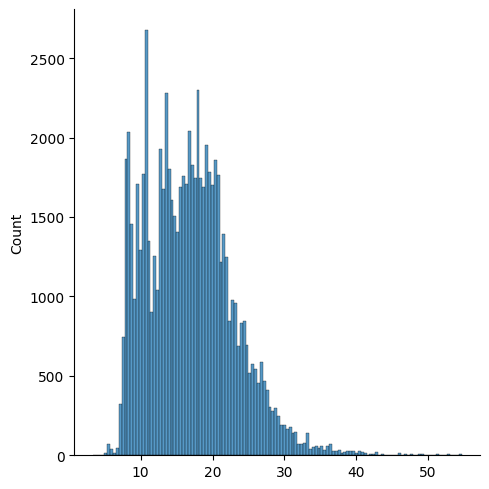

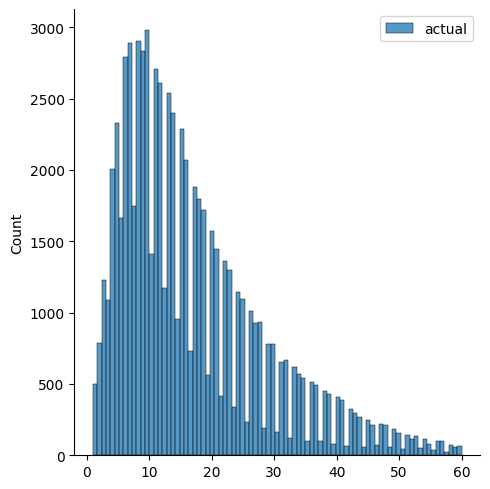

In [25]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

In [26]:
mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829577

In [27]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [28]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [29]:
len(df_train), len(df_val)

(73908, 61921)

In [30]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [31]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [32]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


10.499110712717727

In [33]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


10.481255832596219

In [34]:
lr = Ridge(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


10.47641000263633

In [35]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [36]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,PU_DO
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.00,...,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667,130_205
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.50,...,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000,152_244
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.50,...,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000,152_48
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.00,...,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333,152_241
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.50,...,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667,75_42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64567,2,2021-02-28 22:19:00,2021-02-28 22:29:00,None,NaN,129,7,NaN,2.63,10.04,...,0.00,0.0,None,0.3,10.34,NaN,NaN,NaN,10.000000,129_7
64568,2,2021-02-28 23:18:00,2021-02-28 23:27:00,None,NaN,116,166,NaN,1.87,8.33,...,1.89,0.0,None,0.3,10.52,NaN,NaN,NaN,9.000000,116_166
64569,2,2021-02-28 23:44:00,2021-02-28 23:58:00,None,NaN,74,151,NaN,2.40,12.61,...,0.00,0.0,None,0.3,12.91,NaN,NaN,NaN,14.000000,74_151
64570,2,2021-02-28 23:07:00,2021-02-28 23:14:00,None,NaN,42,42,NaN,1.11,11.95,...,0.00,0.0,None,0.3,15.00,NaN,NaN,NaN,7.000000,42_42


In [37]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [38]:
with mlflow.start_run():

    mlflow.set_tag("developer", "diana")
    mlflow.log_param("train-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
    mlflow.log_param("val-data-path", 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)

    lr = Lasso()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [40]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [41]:
# def objective(params):
#     with mlflow.start_run():
#         mlflow.set_tag("model", "xgboost")
#         mlflow.log_params(params)
#         booster = xgb.train(
#             params=params,
#             dtrain=train,
#             num_boost_round=1000,
#             evals=[(valid, 'validation')],
#             early_stopping_rounds=50
#         )
#         y_pred = booster.predict(valid)
#         rmse = mean_squared_error(y_val, y_pred, squared=False)
#         mlflow.log_metric("rmse", rmse)

#     return {'loss': rmse, 'status': STATUS_OK}

In [42]:
# search_space = {
#     'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
#     'learning_rate': hp.loguniform('learning_rate', -3, 0),
#     'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
#     'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
#     'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
#     'objective': 'reg:linear',
#     'seed': 42
# }

# best_result = fmin(
#     fn=objective,
#     space=search_space,
#     algo=tpe.suggest,
#     max_evals=50,
#     trials=Trials()
# )

In [43]:
mlflow.xgboost.autolog(disable=True)

In [44]:
with mlflow.start_run():

    best_params = {
        'learning_rate' : 0.09585355369315604,
        'max_depth' : 30,
        'min_child_weight' : 1.060597050922164,
        'objective' : 'reg:linear',
        'reg_alpha' : 0.018060244040060163,
        'reg_lambda' : 0.011658731377413597,
        'seed' : 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)

    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:43:47] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.42590
[1]	validation-rmse:10.73579
[2]	validation-rmse:10.13221
[3]	validation-rmse:9.60467
[4]	validation-rmse:9.14350
[5]	validation-rmse:8.74783
[6]	validation-rmse:8.40625
[7]	validation-rmse:8.10997
[8]	validation-rmse:7.85840
[9]	validation-rmse:7.64037
[10]	validation-rmse:7.45297
[11]	validation-rmse:7.29362
[12]	validation-rmse:7.15680
[13]	validation-rmse:7.04125
[14]	validation-rmse:6.94028
[15]	validation-rmse:6.85573
[16]	validation-rmse:6.78299
[17]	validation-rmse:6.71884
[18]	validation-rmse:6.66419
[19]	validation-rmse:6.61703
[20]	validation-rmse:6.57526
[21]	validation-rmse:6.53977
[22]	validation-rmse:6.50992
[23]	validation-rmse:6.48222
[24]	validation-rmse:6.45739
[25]	validation-rmse:6.43638
[26]	validation-rmse:6.41823
[27]	validation-rmse:6.40113
[28]	validation-rmse:6.38730
[29]	validation-rmse:6.37475
[30]	validation-rmse:6.36221
[31]	validation-rmse:6.35130
[32]	validation-rmse:6.34307
[33]	validation-rmse:6.33527
[34]	validation-rmse:

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:44:04] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [45]:
logged_model = 'runs:/f03d1f225a714b4e8113e5883ef4f3ae/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:44:06] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [46]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: f03d1f225a714b4e8113e5883ef4f3ae

In [47]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:44:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [48]:
y_pred = xgboost_model.predict(valid)

In [49]:
y_pred[:10]

array([15.595796 ,  6.781599 , 15.627891 , 23.488264 ,  9.777924 ,
       15.758822 , 10.558309 ,  7.9649777,  8.765656 , 17.269102 ],
      dtype=float32)

In [55]:
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"

client = MlflowClient(tracking_uri=MLFLOW_TRACKING_URI)

In [60]:
client.search_experiments()

[<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1716962613989, experiment_id='2', last_update_time=1716962613989, lifecycle_stage='active', name='nyc-green-taxi-homework', tags={}>,
 <Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716802920555, experiment_id='1', last_update_time=1716802920555, lifecycle_stage='active', name='nyc-green-taxi', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1716802452725, experiment_id='0', last_update_time=1716802452725, lifecycle_stage='active', name='Default', tags={}>]

In [61]:
client.create_experiment(name="test")

'3'

In [67]:
from mlflow.entities import ViewType

runs = client.search_runs(
    experiment_ids="1",
    filter_string="metrics.rmse < 7.0",
    run_view_type=ViewType.ACTIVE_ONLY,
    max_results=5,
    order_by=["metrics.rmse ASC"]
)

In [68]:
for run in runs:
    print(f"run id: {run.info.run_id}, rmse: {run.data.metrics['rmse']:.4f}")

run id: 9653b25a41724555962301fe4e1a9f57, rmse: 6.1644
run id: 6695edf0a74e406e8edee56b96e8c0f1, rmse: 6.1685
run id: f375038ef1ea4deb8cd2f9120f97feca, rmse: 6.1737
run id: 02744390749b479b8114cd08d3091613, rmse: 6.1756
run id: 72c4b3a813f34121b810e2c1a3daaf7e, rmse: 6.1822


In [69]:
import mlflow

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [98]:
# run_id = "91de99c84014a473a9dd552cd5f60eff7"
# model_uri = f"runs:/{run_id}/model"
# mlflow.register_model(model_uri=model_uri, name="nyc-green-taxi")

In [72]:
client.search_registered_models()

[<RegisteredModel: aliases={}, creation_timestamp=1716975908229, description='', last_updated_timestamp=1716977727895, latest_versions=[<ModelVersion: aliases=[], creation_timestamp=1716975965095, current_stage='Staging', description='', last_updated_timestamp=1716976038951, name='nyc-green-taxi', run_id='df3204ac41f64eae914f404eee67f9ff', run_link='', source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/df3204ac41f64eae914f404eee67f9ff/artifacts/models_mlflow', status='READY', status_message=None, tags={}, user_id=None, version=2>,
  <ModelVersion: aliases=[], creation_timestamp=1716977727895, current_stage='None', description=None, last_updated_timestamp=1716977727895, name='nyc-green-taxi', run_id='9653b25a41724555962301fe4e1a9f57', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/9653b25a41724555962301fe4e1a9f57/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>], name='nyc-green-taxi', tags={}>]

In [73]:
model_name = "nyc-green-taxi"
latest_versions = client.get_latest_versions(name=model_name)

for version in latest_versions:
    print(f"versions: {version.version}, stage: {version.current_stage}")

versions: 2, stage: Staging
versions: 3, stage: None


/tmp/ipykernel_2605/2032333782.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  latest_versions = client.get_latest_versions(name=model_name)


In [77]:
model_version = 3
new_stage = "Staging"

client.transition_model_version_stage(
    name=model_name,
    version=model_version,
    stage=new_stage,
    archive_existing_versions=False
)

/tmp/ipykernel_2605/2949610654.py:4: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1716977727895, current_stage='Staging', description=None, last_updated_timestamp=1716978377111, name='nyc-green-taxi', run_id='9653b25a41724555962301fe4e1a9f57', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/9653b25a41724555962301fe4e1a9f57/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [78]:
from datetime import datetime
date = datetime.today().date()

client.update_model_version(
    name=model_name,
    version=model_version,
    description=f"The model version {model_version} was transition to {new_stage} on {date}"
)

<ModelVersion: aliases=[], creation_timestamp=1716977727895, current_stage='Staging', description='The model version 3 was transition to Staging on 2024-05-29', last_updated_timestamp=1716978446396, name='nyc-green-taxi', run_id='9653b25a41724555962301fe4e1a9f57', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/9653b25a41724555962301fe4e1a9f57/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>

In [80]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)

    return df


def preprocess(df, dv):
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    categorical = ['PU_DO']
    numerical = ['trip_distance']
    dicts = df[categorical + numerical].to_dict(orient='records')
    return dv.transform(train_dicts)

def test_model(name, stage, X_test, y_test, ):
    model = mlflow.pyfunc.load_model(f"models:/{name}/{stage}")
    y_pred = model.predict(X_test)
    return {"rmse": mean_squared_error(y_test, y_pred, squared=False)}

In [81]:
df = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-03.parquet")

In [88]:
run_id = '1de99c84014a473a9dd552cd5f60eff7'

client.download_artifacts(run_id=run_id, path='preprocessor', dst_path='.')

'/workspaces/mlops-zoomcamp/02-experiment-tracking/preprocessor'

In [89]:
import pickle

with open("preprocessor/preprocessor.b", "rb") as f_in:
    dv = pickle.load(f_in)


In [90]:
X_test = preprocess(df, dv)

In [91]:
target = "duration"
y_test = df[target].values

In [99]:
# %time test_model(name=model_name, stage="Production", X_test=X_test, y_test=y_test)

In [100]:
# %time test_model(name=model_name, stage="Staging", X_test=X_test, y_test=y_test)

In [97]:
client.transition_model_version_stage(
    name=model_name,
    version=3,
    stage="Production",
    archive_existing_versions=True
)

/tmp/ipykernel_2605/684772386.py:1: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.13.0/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


<ModelVersion: aliases=[], creation_timestamp=1716977727895, current_stage='Production', description='The model version 3 was transition to Staging on 2024-05-29', last_updated_timestamp=1716980226166, name='nyc-green-taxi', run_id='9653b25a41724555962301fe4e1a9f57', run_link=None, source='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1/9653b25a41724555962301fe4e1a9f57/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=3>